In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy

In [2]:
def get_groups_and_return_genes_and_species(taxa_level):

    #Import packages
    import pandas as pd
    import numpy as np 
    

    #Read in used files 
    ortho_groups_to_genes = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_OG2genes.tab',sep = '\t',names = 
        ['Group ID','Gene ID'])
    ortho_groups_to_taxa = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_OGs.tab', sep = '\t',names = 
        ['Group ID','taxa_ID','Group Name'])
    ortho_genes_to_species = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_genes.tab', sep = '\t',names = 
        ['Gene ID','species_ID','Protein seq','synonyms','Uniprot','Ensembl','NCBI','Description'])
    indexed_ortho_genes = ortho_genes_to_species.set_index('Gene ID')
    coconet_plants = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/tax_report.txt', sep = '\t')
    coconet_plants.drop(['code','|','|.1','|.2','preferred name'],axis = 1,inplace=True)

    # Get the groups 
    ortho_groups_built_on_taxa_lvl = ortho_groups_to_taxa.loc[ortho_groups_to_taxa['taxa_ID'] == taxa_level ]
    ortho_list_taxa_lvl = ortho_groups_built_on_taxa_lvl['Group ID']
    ortho_genes_in_taxa_groups = ortho_groups_to_genes.loc[ortho_groups_to_genes['Group ID'].isin(ortho_list_taxa_lvl.to_list())]

    #Drop Duplicates 
    ortho_genes_in_taxa_groups.drop_duplicates(subset ='Gene ID',inplace=True)
    #Clean Species ID
    ortho_genes_in_taxa_groups['Species ID'] = ortho_genes_in_taxa_groups['Gene ID'].str.partition('_')[0]

    #Drop Species not in CococoNet 
    ortho_genes_in_taxa_cocoplants = ortho_genes_in_taxa_groups.loc[ortho_genes_in_taxa_groups['Species ID'].isin(list(map(str,
        coconet_plants['taxid'].to_list())))]
    #Get Gene and Common Name mapping    
    ortho_genes_in_taxa_cocoplants.merge(right =ortho_genes_to_species[['Gene ID','Uniprot','Ensembl','NCBI']], on = 'Gene ID',how = 'left')   
    coconet_plants.columns =['Common Name', 'Species ID']
    coconet_typed = coconet_plants.astype({'Species ID':'str'})
    ortho_genes_in_taxa_cocoplants.merge(right = coconet_typed, on = 'Species ID',how = 'left' )  

    return ortho_genes_in_taxa_cocoplants


def read_cococonet(file_location):
    import h5py
    net = h5py.File(file_location,'r')
    agg_dataset = net['agg'] 
    row_dataset = net['row']
    col_dataset = net['col']
    row_gene_list = []
    for gene in row_dataset:
        row_gene_list.append(gene.decode('UTF-8'))
    col_gene_list = []
    for gene in col_dataset: 
        col_gene_list.append(gene.decode('UTF-8'))
    net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
    net.close()
    return net_df

In [3]:
eudicot_groups = get_groups_and_return_genes_and_species(71240)
eudicot_groups

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/tmp/ipykernel_2248781/1508435818.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_genes_in_taxa_groups.drop_duplicates(subset ='Gene ID',inplace=True)
/tmp/ipykernel_2248781/1508435818.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_genes_in_taxa_groups['Species ID'] = ortho_genes_in_taxa

,Group ID,Gene ID,Species ID
19314,100004at71240,29760_0:000a7f,29760
19341,100004at71240,3702_0:002244,3702
19342,100004at71240,3711_0:0096e0,3711
19344,100004at71240,3750_0:000894,3750
19345,100004at71240,3750_0:00624e,3750
...,...,...,...
195683137,99991at71240,4097_0:0061df,4097
195683138,99991at71240,4097_0:0071a2,4097
195683139,99991at71240,4097_0:0080b8,4097
195683144,99991at71240,4113_0:00232e,4113


In [4]:
### Import Intersect gene database, map to arabidopsis, pull genes, check functional conservation vs a monocot, a mustard and a dicot 
primary_secondary_genes = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/primary_secondary_metabolism_genes.csv')
primary_secondary_genes.drop(primary_secondary_genes.columns.difference(['TAIR gene name','Instances defined as Intersection model ']),1, inplace = True)
primary_secondary_genes.rename(columns = {'Instances defined as Intersection model ': 'Instances defined as Intersection model','TAIR gene name':'sp2_gene'},inplace = True)
primary_secondary_genes.dropna(inplace = True)
primary_secondary_genes


,sp2_gene,Instances defined as Intersection model
1,AT5G10920,GM
2,AT4G02580,GM
3,AT5G52840,GM
5,AT3G10700,GM
6,AT1G19580,GM
...,...,...
1498,AT1G77530,SM
1538,AT5G37170,SM
1588,AT2G38240,SM
1644,AT5G59530,SM


In [5]:
mustard_arabdidopsis_functional_conservation = pd.read_csv('/home/passala/Gene_duplication_project/Networks/N_M_files/mustard_arabidopsis_prio_NM.csv')
fc_sc_map = primary_secondary_genes.merge(mustard_arabdidopsis_functional_conservation,on = 'sp2_gene',how = 'left')
sm_genes = fc_sc_map.loc[fc_sc_map['Instances defined as Intersection model'].str.match('SM')]
sm_genes.dropna(inplace = True)
gm_genes = fc_sc_map.loc[fc_sc_map['Instances defined as Intersection model'].str.match('GM')]
gm_genes.dropna(inplace = True)

/tmp/ipykernel_2248781/3418064687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_genes.dropna(inplace = True)
/tmp/ipykernel_2248781/3418064687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_genes.dropna(inplace = True)


In [6]:
list_of_arabidopsis_paths = ['/home/passala/Gene_duplication_project/Networks/N_M_files/apple_arabidopsis_prio_NM.csv','/home/passala/Gene_duplication_project/Networks/N_M_files/arabidopsis_maize_prio_NM.csv']

In [7]:
sm_genes

,sp2_gene,Instances defined as Intersection model,sp1_gene,fc,sc
1036,AT4G13660,SM,LOC103868905,0.515266,0.800483
1037,AT3G24503,SM,LOC103860041,0.708449,0.878474
1038,AT4G30550,SM,LOC103852592,0.376286,0.320624
1039,AT4G30550,SM,LOC103861974,0.401478,0.404754
1040,AT4G30550,SM,LOC103834668,0.455356,0.566676
1041,AT4G30550,SM,LOC103834667,0.648294,0.630851
1042,AT5G13930,SM,LOC103850907,0.855481,0.996366
1043,AT5G13930,SM,LOC103846527,0.878110,0.997869
1045,AT4G30530,SM,LOC103852592,0.942850,0.999657
1046,AT4G30530,SM,LOC103861974,0.881806,0.998296


In [8]:
def get_sm_and_gm_pandas(species_id):
    taxa_mapper = pd.read_csv('/home/passala/Gene_duplication_project/Generated_tables/Time_Savers/coconet_nm_prio_plant_paths.csv')
    species_path =  taxa_mapper['Path'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
    species_name =  taxa_mapper['Species'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
    functional_conservation = pd.read_csv(species_path)
    fc_sc_map = primary_secondary_genes.merge(functional_conservation,on = 'sp2_gene',how = 'left')
    sm_genes = fc_sc_map.loc[fc_sc_map['Instances defined as Intersection model'].str.match('SM')]
    sm_genes.replace('SM*','SM',inplace = True)
    sm_genes.dropna(inplace = True)
    gm_genes = fc_sc_map.loc[fc_sc_map['Instances defined as Intersection model'].str.match('GM')]
    gm_genes.dropna(inplace = True)
    return sm_genes,gm_genes,species_name






In [9]:
rice_sm,rice_gm,name = get_sm_and_gm_pandas(29760)
name

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/tmp/ipykernel_2248781/1879200469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_genes.dropna(inplace = True)
/tmp/ipykernel_2248781/1879200469.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_genes.dropna(inplace = True)


'Vitis vinifera'

In [10]:
list_of_eudicots_to_compare = [4097,4081,4113,29760,3750,3711,3847,3880]

In [11]:
rice_sm

,sp2_gene,Instances defined as Intersection model,sp1_gene,fc,sc
1049,AT4G13660,SM,LOC100243193,0.554474,0.658594
1050,AT4G13660,SM,IFRL1,0.474622,0.840597
1051,AT4G13660,SM,LOC100248319,0.553276,0.895049
1052,AT4G13660,SM,LOC100259918,0.527046,0.682678
1054,AT4G30550,SM,LOC100259085,0.577466,0.498704
...,...,...,...,...,...
1139,AT5G59530,SM,LOC100264824,0.418575,0.261413
1140,AT5G59530,SM,LOC104879286,0.517424,0.921417
1141,AT5G59530,SM,LOC100251563,0.352131,0.383514
1142,AT5G59530,SM,LOC100260734,0.312494,0.266881


In [12]:
eudicot_metabolism_divergence = pd.DataFrame(columns = ['Metabolism Type','Score','Species','Score Type'])
for eudicot in list_of_eudicots_to_compare:
    current_sm_pd,current_gm_pd,current_name = get_sm_and_gm_pandas(eudicot)
    current_sm_pd['Species'] = current_name
    current_sm_fc = current_sm_pd.drop(columns = ['sp2_gene','sc','sp1_gene'])
    current_sm_fc = current_sm_fc.rename(columns = {'fc':'Score','Instances defined as Intersection model':'Metabolism Type'})
    current_sm_fc['Score Type'] = 'FC'

    eudicot_metabolism_divergence = eudicot_metabolism_divergence.append(current_sm_fc,ignore_index = True)

    current_sm_sc = current_sm_pd.drop(columns = ['sp2_gene','fc','sp1_gene'])
    current_sm_sc = current_sm_sc.rename(columns = {'sc':'Score','Instances defined as Intersection model':'Metabolism Type'})
    current_sm_sc['Score Type'] = 'SC'

    eudicot_metabolism_divergence = eudicot_metabolism_divergence.append(current_sm_sc,ignore_index = True)

    current_gm_pd['Species'] = current_name
    current_gm_fc = current_gm_pd.drop(columns = ['sp2_gene','sc','sp1_gene'])
    current_gm_fc = current_gm_fc.rename(columns = {'fc':'Score','Instances defined as Intersection model':'Metabolism Type'})
    current_gm_fc['Score Type'] = 'FC'

    eudicot_metabolism_divergence = eudicot_metabolism_divergence.append(current_gm_fc,ignore_index = True)

    current_gm_sc = current_gm_pd.drop(columns = ['sp2_gene','fc','sp1_gene'])
    current_gm_sc = current_gm_sc.rename(columns = {'sc':'Score','Instances defined as Intersection model':'Metabolism Type'})
    current_gm_sc['Score Type'] = 'SC' 

    
    eudicot_metabolism_divergence = eudicot_metabolism_divergence.append(current_gm_sc,ignore_index = True)
eudicot_metabolism_divergence


/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/tmp/ipykernel_2248781/1879200469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_genes.dropna(inplace = True)
/tmp/ipykernel_2248781/1879200469.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_genes.dropna(inplace = True)
/home/passala/miniconda3/envs/py39/lib/pyt

,Metabolism Type,Score,Species,Score Type
0,SM,0.584970,Nicotiana tabacum,FC
1,SM,0.649382,Nicotiana tabacum,FC
2,SM,0.589569,Nicotiana tabacum,FC
3,SM,0.623162,Nicotiana tabacum,FC
4,SM,0.794806,Nicotiana tabacum,FC
...,...,...,...,...
14645,GM,0.419204,Medicago truncatula,SC
14646,GM,0.501380,Medicago truncatula,SC
14647,GM,0.507620,Medicago truncatula,SC
14648,GM,0.984870,Medicago truncatula,SC


In [13]:
just_brassica_for_plot = eudicot_metabolism_divergence.loc[(eudicot_metabolism_divergence['Score Type'].str.match('FC')) &(eudicot_metabolism_divergence['Species']=='Brassica rapa')]

In [14]:
just_brassica_for_plot

,Metabolism Type,Score,Species,Score Type
10616,SM,0.515266,Brassica rapa,FC
10617,SM,0.708449,Brassica rapa,FC
10618,SM,0.376286,Brassica rapa,FC
10619,SM,0.401478,Brassica rapa,FC
10620,SM,0.455356,Brassica rapa,FC
...,...,...,...,...
11564,GM,0.317222,Brassica rapa,FC
11565,GM,0.247263,Brassica rapa,FC
11566,GM,0.656588,Brassica rapa,FC
11567,GM,0.497582,Brassica rapa,FC


In [15]:
my_pal = {'SM':'tab:red','GM':'tab:orange'}

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

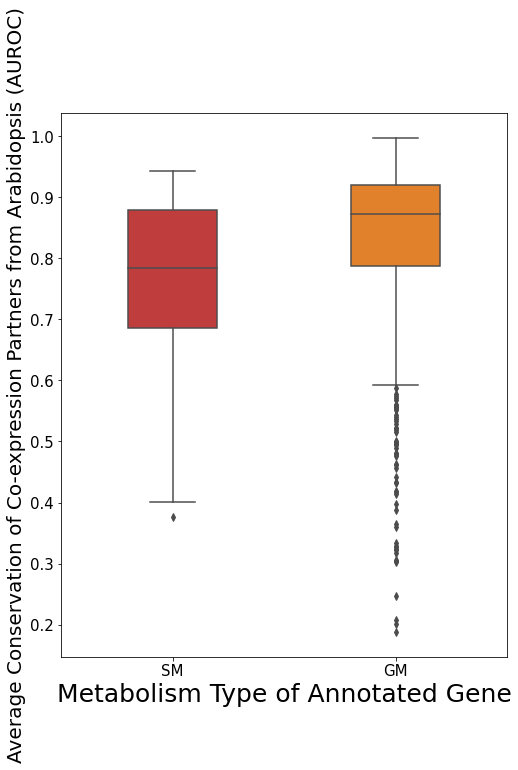

In [16]:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'Score',x = 'Metabolism Type', data = just_brassica_for_plot, width = .4, palette = my_pal)
plt.ylabel("Average Conservation of Co-expression Partners from Arabidopsis (AUROC)", fontsize = 20)
plt.xlabel("Metabolism Type of Annotated Gene", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


In [60]:
eudicot_metabolism_divergence.loc[eudicot_metabolism_divergence['Score Type'].str.match('FC')]

,Metabolism Type,Score,Species,Score Type
0,SM,0.584970,Nicotiana tabacum,FC
1,SM,0.649382,Nicotiana tabacum,FC
2,SM,0.589569,Nicotiana tabacum,FC
3,SM,0.623162,Nicotiana tabacum,FC
4,SM,0.794806,Nicotiana tabacum,FC
...,...,...,...,...
13700,GM,0.428499,Medicago truncatula,FC
13701,GM,0.389799,Medicago truncatula,FC
13702,GM,0.339313,Medicago truncatula,FC
13703,GM,0.722662,Medicago truncatula,FC


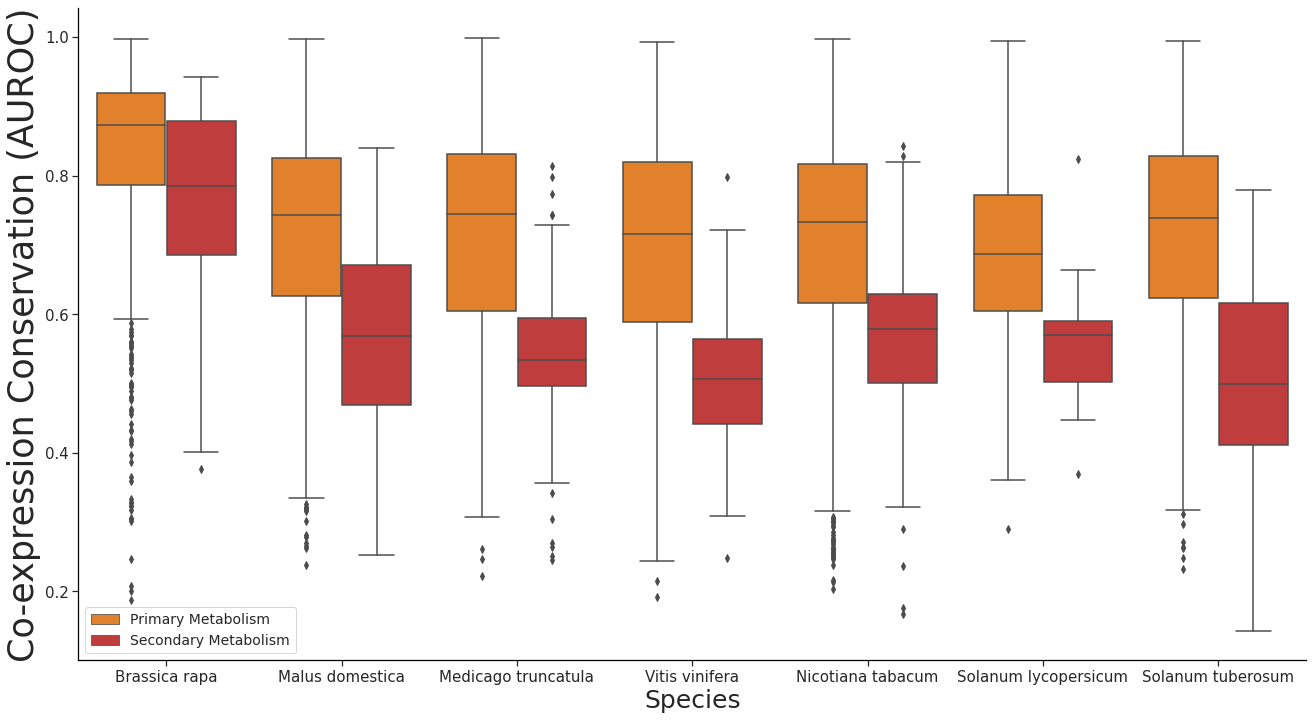

In [59]:
my_pal = {'SM':'tab:red','GM':'tab:orange'}
fig, ax = plt.subplots(figsize = (22,12))
sns.set_theme(style = 'ticks')
sns.boxplot(ax = ax, y = 'Score',x = 'Species',hue = 'Metabolism Type', data = eudicot_metabolism_divergence.loc[eudicot_metabolism_divergence['Score Type'].str.match('FC')].iloc[::-1], order = ['Brassica rapa','Malus domestica','Medicago truncatula','Vitis vinifera','Nicotiana tabacum','Solanum lycopersicum','Solanum tuberosum'], palette = my_pal)
#order = ['Brassica rapa','Malus domestica','Medicago truncatula','Vitis vinifera','Solanum lycoperiscum','Nicotiana tabacum','Solanum tuberosum']
plt.xlabel("Species", fontsize = 25)
plt.ylabel("Co-expression Conservation (AUROC)", fontsize = 35)
sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
L = plt.legend(fontsize= 14,markerscale = 1.5, loc = 'lower left',)
L.get_texts()[0].set_text('Primary Metabolism')
L.get_texts()[1].set_text('Secondary Metabolism')


In [19]:
fc_only_metabolism_diverge = eudicot_metabolism_divergence.loc[(eudicot_metabolism_divergence['Score Type'].str.match('FC'))] 

In [20]:
list_of_species_for_graph  = ['Brassica rapa','Malus domestica','Medicago truncatula','Vitis vinifera','Solanum lycopersicum','Nicotiana tabacum','Solanum tuberosum']
list_of_distances = [25.6,106,106,110,117,117,117]

In [21]:
fc_only_metabolism_diverge

,Metabolism Type,Score,Species,Score Type
0,SM,0.584970,Nicotiana tabacum,FC
1,SM,0.649382,Nicotiana tabacum,FC
2,SM,0.589569,Nicotiana tabacum,FC
3,SM,0.623162,Nicotiana tabacum,FC
4,SM,0.794806,Nicotiana tabacum,FC
...,...,...,...,...
13700,GM,0.428499,Medicago truncatula,FC
13701,GM,0.389799,Medicago truncatula,FC
13702,GM,0.339313,Medicago truncatula,FC
13703,GM,0.722662,Medicago truncatula,FC


In [22]:
gm_lists = []
sm_lists = []
for plant_species,distance in zip(list_of_species_for_graph,list_of_distances):
    current_gm_avg_score = fc_only_metabolism_diverge.loc[(fc_only_metabolism_diverge['Metabolism Type'] == 'GM') & (fc_only_metabolism_diverge['Species'] == plant_species)]['Score'].mean()
    current_gm_avg = ['GM',current_gm_avg_score,plant_species,distance]
    gm_lists.append(current_gm_avg)
    current_sm_avg_score = fc_only_metabolism_diverge.loc[(fc_only_metabolism_diverge['Metabolism Type'] == 'SM') & (fc_only_metabolism_diverge['Species'] == plant_species)]['Score'].mean()
    current_sm_avg = ['SM',current_sm_avg_score,plant_species,distance]
    sm_lists.append(current_sm_avg)
    

In [23]:
gm_lists.extend(sm_lists)
gm_lists


[['GM', 0.8345564614000777, 'Brassica rapa', 25.6],
 ['GM', 0.7165054550683092, 'Malus domestica', 106],
 ['GM', 0.7110542229791426, 'Medicago truncatula', 106],
 ['GM', 0.6949572112482224, 'Vitis vinifera', 110],
 ['GM', 0.6903800688927872, 'Solanum lycopersicum', 117],
 ['GM', 0.7052420119410504, 'Nicotiana tabacum', 117],
 ['GM', 0.7138420614798057, 'Solanum tuberosum', 117],
 ['SM', 0.7490304999746078, 'Brassica rapa', 25.6],
 ['SM', 0.5671295314657824, 'Malus domestica', 106],
 ['SM', 0.5420942345933605, 'Medicago truncatula', 106],
 ['SM', 0.5032606008069668, 'Vitis vinifera', 110],
 ['SM', 0.55616017697592, 'Solanum lycopersicum', 117],
 ['SM', 0.5674765416029802, 'Nicotiana tabacum', 117],
 ['SM', 0.5052475764206128, 'Solanum tuberosum', 117]]

In [24]:
averaged_metabolism = pd.DataFrame(data = gm_lists, columns = ['Metabolism Type','Conservation of Co-expression Partners (AUROC)','Species','Distance'])
averaged_metabolism

,Metabolism Type,Conservation of Co-expression Partners (AUROC),Species,Distance
0,GM,0.834556,Brassica rapa,25.6
1,GM,0.716505,Malus domestica,106.0
2,GM,0.711054,Medicago truncatula,106.0
3,GM,0.694957,Vitis vinifera,110.0
4,GM,0.690380,Solanum lycopersicum,117.0
5,GM,0.705242,Nicotiana tabacum,117.0
6,GM,0.713842,Solanum tuberosum,117.0
7,SM,0.749030,Brassica rapa,25.6
8,SM,0.567130,Malus domestica,106.0
9,SM,0.542094,Medicago truncatula,106.0


Text(0, 0.5, 'Conservation of Co-expression Partners (AUROC) vs Arabidopsis')

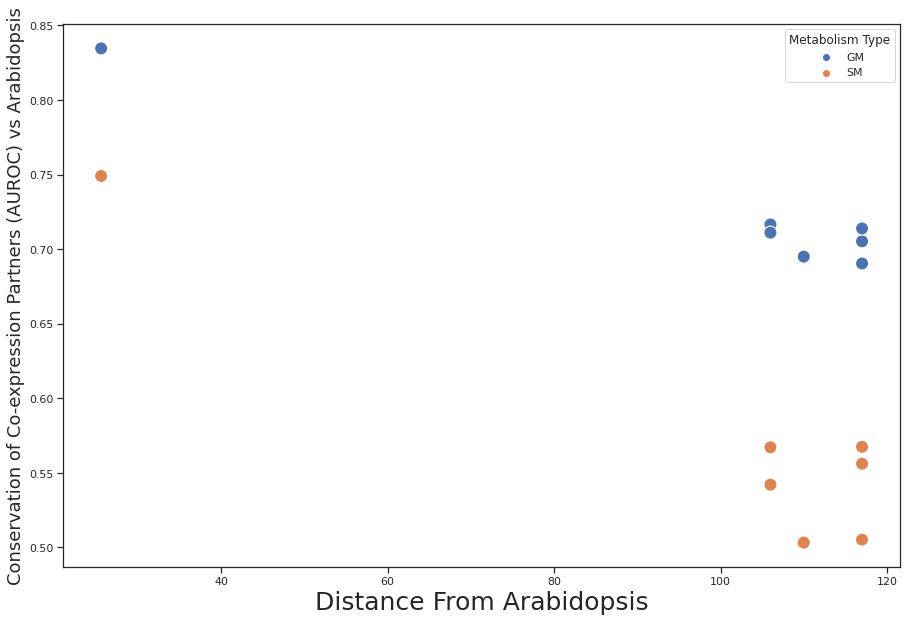

In [25]:
fig, ax = plt.subplots(figsize = (15,10))
sns.scatterplot(data = averaged_metabolism, x = 'Distance', y = 'Conservation of Co-expression Partners (AUROC)', hue = 'Metabolism Type', s = 170)
plt.xlabel("Distance From Arabidopsis", fontsize = 25)
plt.ylabel("Conservation of Co-expression Partners (AUROC) vs Arabidopsis", fontsize = 18)

In [26]:
fc_only_metabolism_diverge.loc[(fc_only_metabolism_diverge['Metabolism Type'] == 'GM') & (fc_only_metabolism_diverge['Species'] == 'Medicago truncatula')]['Score'].mean()

0.7110542229791426

<AxesSubplot:xlabel='Species', ylabel='Score'>

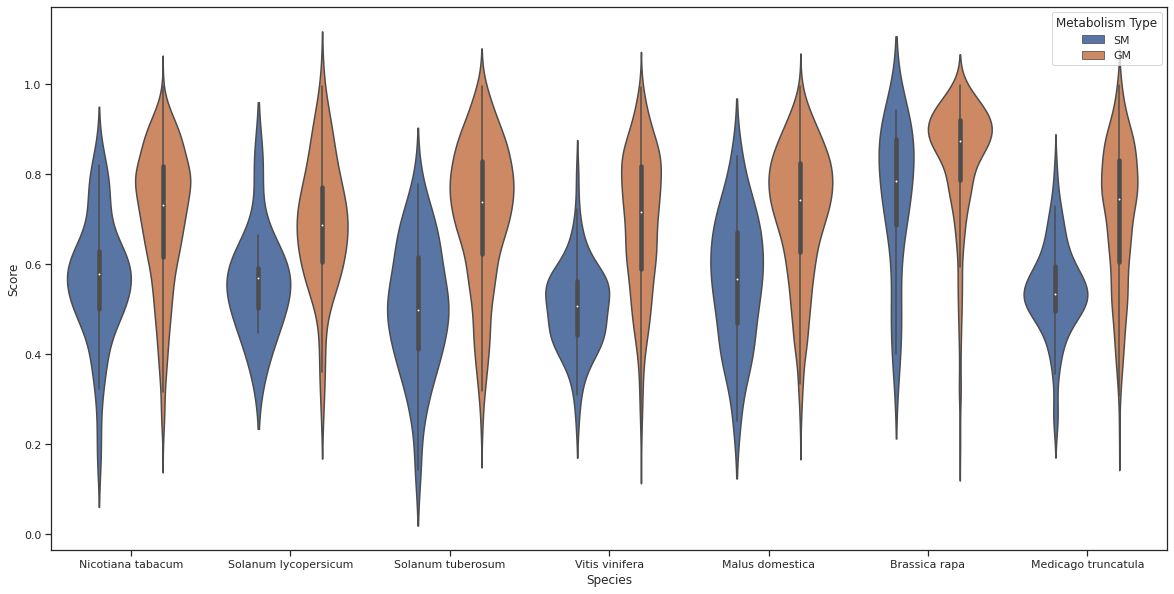

In [27]:
fig, ax = plt.subplots(figsize = (20,10))
sns.set_theme(style = 'ticks')
sns.violinplot(ax = ax, y = 'Score',x = 'Species',hue = 'Metabolism Type', data = eudicot_metabolism_divergence.loc[eudicot_metabolism_divergence['Score Type'].str.match('FC')] )

In [28]:
tester = eudicot_metabolism_divergence.loc[eudicot_metabolism_divergence['Score Type'].str.match('FC')]
tester.loc[tester['Metabolism Type'].str.match('GM')].median()

Score    0.753037
dtype: float64

In [29]:
rice_sm['Species'] = 'rice'
rice_sm_fc = rice_sm.drop(columns = ['sp2_gene','sc','sp1_gene'])
rice_sm_fc = rice_sm_fc.rename(columns = {'fc':'Score','Instances defined as Intersection model':'Metabolism Type'})
rice_sm_fc['Score Type'] = 'FC'
rice_sm_fc

,Metabolism Type,Score,Species,Score Type
1049,SM,0.554474,rice,FC
1050,SM,0.474622,rice,FC
1051,SM,0.553276,rice,FC
1052,SM,0.527046,rice,FC
1054,SM,0.577466,rice,FC
...,...,...,...,...
1139,SM,0.418575,rice,FC
1140,SM,0.517424,rice,FC
1141,SM,0.352131,rice,FC
1142,SM,0.312494,rice,FC


In [30]:
test_Frame = pd.DataFrame(columns = ['Metabolism Type','Score','Species','Score Type'])
test_Frame

,Metabolism Type,Score,Species,Score Type


In [31]:
taxa_report = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/tax_report.txt', sep = '\t')
taxa_report

,code,|,name,|.1,preferred name,|.2,taxid
0,1,|,Oryza sativa,|,,|,4530
1,1,|,Brachypodium distachyon,|,,|,15368
2,1,|,Sorghum bicolor,|,,|,4558
3,1,|,Zea mays,|,,|,4577
4,1,|,Vitis vinifera,|,,|,29760
5,1,|,Arabidopsis thaliana,|,,|,3702
6,1,|,Brassica rapa,|,,|,3711
7,1,|,Brassica napus,|,,|,3708
8,1,|,Cucumis sativus,|,,|,3659
9,1,|,Glycine max,|,,|,3847


In [32]:
species_taxid_path = [['Oryza sativa',4530,'/home/passala/Gene_duplication_project/Networks/N_M_files/arabidopsis_rice_prio_NM.csv'],['Malus domestica',3750,'/home/passala/Gene_duplication_project/Networks/N_M_files/apple_arabidopsis_prio_NM.csv'],['Sorghum bicolor',4558,'/home/passala/Gene_duplication_project/Networks/N_M_files/sorghum_arabidopsis_meta_NM.csv'],['Zea mays',4577,'/home/passala/Gene_duplication_project/Networks/N_M_files/arabidopsis_maize_prio_NM.csv'],['Vitis vinifera',29760,'/home/passala/Gene_duplication_project/Networks/N_M_files/grape_arabidopsis_prio_NM.csv'],['Brassica rapa',3711,'/home/passala/Gene_duplication_project/Networks/N_M_files/mustard_arabidopsis_prio_NM.csv'],['Glycine max',3847,'/home/passala/Gene_duplication_project/Networks/N_M_files/arabidopsis_soybean_prio_NM.csv'],['Medicago truncatula',3880,'/home/passala/Gene_duplication_project/Networks/N_M_files/medicago_arabidopsis_prio_NM.csv'],['Malus domestica',3750,'/home/passala/Gene_duplication_project/Networks/N_M_files/apple_arabidopsis_prio_NM.csv'],['Nicotiana tabacum',4097,'/home/passala/Gene_duplication_project/Networks/N_M_files/tobacco_arabidopsis_prio_NM.csv'],['Solanum tuberosum',4113,'/home/passala/Gene_duplication_project/Networks/N_M_files/potato_arabidopsis_prio_NM.csv'],['Solanum lycopersicum',4081,'/home/passala/Gene_duplication_project/Networks/N_M_files/tomato_arabidopsis_prio_NM.csv']]


In [33]:
#species_taxa_path = pd.DataFrame(species_taxid_path,columns = ['Species','Taxa ID','Path'])
#species_taxa_path.to_csv('/home/passala/Gene_duplication_project/Generated_tables/Time Savers/coconet_nm_prio_plant_paths.csv')

In [34]:
distance_matrix_full = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/full_distance_matrix.csv')
distance_matrix_full.drop(index =[1,4,9,10,11,12,13,14,15],inplace = True)
distance_matrix_full.drop(columns = ['Oryza sativa','Brachypodium distachyon','Sorghum bicolor','Zea mays','Brassica napus','Cucumis sativus','Arachis hypogaea','Arabidopsis thaliana','Glycine max'], inplace = True)
linkage_map_pd_full = distance_matrix_full.melt(id_vars = ['Unnamed: 0']).dropna()

In [35]:
distance_matrix_full

,Unnamed: 0,Vitis vinifera,Brassica rapa,Malus domestica,Medicago truncatula,Solanum lycopersicum,Nicotiana tabacum,Solanum tuberosum
0,Vitis vinifera,NaN,110.0,110.0,110.0,117.0,117.0,117.00
2,Brassica rapa,NaN,NaN,106.0,106.0,117.0,117.0,117.00
3,Malus domestica,NaN,NaN,NaN,106.0,117.0,117.0,117.00
5,Medicago truncatula,NaN,NaN,NaN,NaN,117.0,117.0,117.00
6,Solanum lycopersicum,NaN,NaN,NaN,NaN,NaN,29.8,7.67
7,Nicotiana tabacum,NaN,NaN,NaN,NaN,NaN,NaN,29.80
8,Solanum tuberosum,NaN,NaN,NaN,NaN,NaN,NaN,NaN


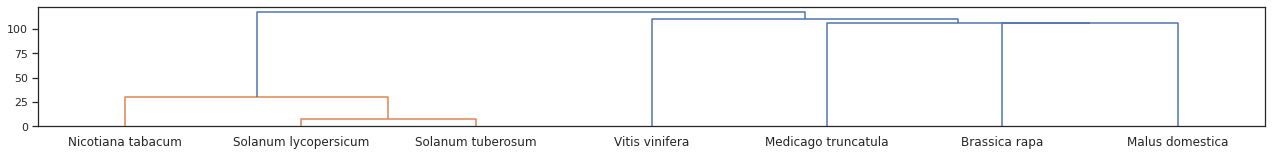

In [36]:

linkage_dictionary_full = {}
for index, species_pair in linkage_map_pd_full.iterrows():
    linkage_dictionary_full[species_pair[0],species_pair[1]] = species_pair[2]
keys_full = [sorted(k) for k in linkage_dictionary_full.keys()]
values_full = linkage_dictionary_full.values()
sorted_keys_full,distances_full = zip(*sorted(zip(keys_full,values_full)))
Z_full = scipy.cluster.hierarchy.linkage(distances_full)
labels_full = sorted(set([key[0] for key in sorted_keys_full] + [sorted_keys_full[-1][-1]]))
plt.figure(num =None, figsize = (22,2.2))
scipy.cluster.hierarchy.dendrogram(Z_full, labels = labels_full,orientation = 'top')
plt.savefig('/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code/Figures/phylogeny.png',dpi=1200)

In [37]:
# distance_matrix_full.drop(index =[1,9,10,11,12,13,14,15],inplace = True)
# distance_matrix_full.drop(columns = ['Oryza sativa','Brachypodium distachyon','Sorghum bicolor','Zea mays','Brassica napus','Cucumis sativus','Arachis hypogaea','Arabidopsis thaliana'], inplace = True)
# distance_matrix_full

In [38]:
arabi_coconet = read_cococonet('/home/passala/Gene_duplication_project/Networks/arabidopsis_prioAggNet.hdf5')
arabi_coconet

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130,ATCG01180,ATCG01210,ATCG01310
AT1G01020,1.000000,0.676041,0.885107,0.916603,0.167027,0.625596,0.801175,0.866369,0.954286,0.715750,...,0.111731,0.193853,0.261697,0.299060,0.321617,0.287853,0.559907,0.017205,0.011806,0.091015
AT1G01030,0.676041,1.000000,0.707718,0.515532,0.420354,0.292083,0.687003,0.626281,0.483536,0.570675,...,0.245167,0.215414,0.255414,0.306986,0.308402,0.270118,0.463394,0.083490,0.059014,0.108780
AT1G01040,0.885107,0.707718,1.000000,0.836387,0.545101,0.701558,0.656258,0.857046,0.657204,0.650843,...,0.155183,0.230038,0.149740,0.334558,0.287951,0.186425,0.219380,0.032348,0.018332,0.057761
AT1G01050,0.916603,0.515532,0.836387,1.000000,0.562112,0.726964,0.837948,0.928252,0.952045,0.640223,...,0.089440,0.177388,0.164935,0.236661,0.251851,0.213062,0.412583,0.046082,0.029016,0.086736
AT1G01060,0.167027,0.420354,0.545101,0.562112,1.000000,0.327202,0.242215,0.304953,0.217415,0.077569,...,0.082518,0.125455,0.103488,0.187982,0.195059,0.125488,0.212731,0.061676,0.057518,0.044208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01120,0.287853,0.270118,0.186425,0.213062,0.125488,0.083681,0.364707,0.333718,0.237716,0.149145,...,0.858389,0.905572,0.926062,0.941864,0.954421,1.000000,0.969018,0.450607,0.357960,0.410586
ATCG01130,0.559907,0.463394,0.219380,0.412583,0.212731,0.077222,0.625678,0.496059,0.428496,0.226147,...,0.881835,0.936241,0.946935,0.958553,0.960399,0.969018,1.000000,0.467233,0.412343,0.483002
ATCG01180,0.017205,0.083490,0.032348,0.046082,0.061676,0.022381,0.090228,0.069825,0.028903,0.015799,...,0.751869,0.781811,0.740045,0.745181,0.676666,0.450607,0.467233,1.000000,0.999090,0.579657
ATCG01210,0.011806,0.059014,0.018332,0.029016,0.057518,0.026014,0.062831,0.043944,0.015468,0.018706,...,0.687306,0.710940,0.676507,0.687223,0.567304,0.357960,0.412343,0.999090,1.000000,0.511263


In [39]:
### Set up Egad- Label 3 columns of genes w/ annotations - SM + GM, SM, GM

primary_secondary_genes
all_secondary_genes = primary_secondary_genes.loc[primary_secondary_genes['Instances defined as Intersection model'].str.match('SM')]
all_primary_genes = primary_secondary_genes.loc[primary_secondary_genes['Instances defined as Intersection model'].str.match('GM')]

In [40]:
all_primary_genes

,sp2_gene,Instances defined as Intersection model
1,AT5G10920,GM
2,AT4G02580,GM
3,AT5G52840,GM
5,AT3G10700,GM
6,AT1G19580,GM
...,...,...
1247,AT4G15320,GM
1250,AT2G32530,GM
1260,AT1G77330,GM
1264,AT1G25054,GM


In [41]:
starting_annotation_pd = pd.DataFrame(data = arabi_coconet.index, columns = ['sp2_gene'])
all_genes_with_annot = starting_annotation_pd.merge(primary_secondary_genes,on = 'sp2_gene',how = 'left')
all_genes_with_annot = all_genes_with_annot.fillna(value = 0)
all_genes_with_annot = all_genes_with_annot.rename({"Instances defined as Intersection model":'SM and GM Genes'},axis = 'columns')
all_genes_with_annot = all_genes_with_annot.replace(to_replace = ['GM','SM','SM*','unknown'], value = [1,1,1,0])


all_genes_with_annot = all_genes_with_annot.merge(all_secondary_genes,on = 'sp2_gene',how = 'left')
all_genes_with_annot = all_genes_with_annot.fillna(value = 0)
all_genes_with_annot = all_genes_with_annot.rename({"Instances defined as Intersection model":'SM Genes'},axis = 'columns')
all_genes_with_annot = all_genes_with_annot.replace(to_replace = ['GM','SM','SM*','unknown'], value = [1,1,1,0])

all_genes_with_annot = all_genes_with_annot.merge(all_primary_genes,on = 'sp2_gene',how = 'left')

all_genes_with_annot = all_genes_with_annot.fillna(value = 0)
all_genes_with_annot = all_genes_with_annot.rename({"Instances defined as Intersection model":'GM Genes'},axis = 'columns')
all_genes_with_annot = all_genes_with_annot.replace(to_replace = ['GM','SM','SM*','unknown'], value = [1,1,1,0])


all_genes_with_annot = all_genes_with_annot.set_index(keys = 'sp2_gene')
all_genes_with_annot
all_genes_with_annot['SM Genes'].value_counts()


0    20848
1       31
Name: SM Genes, dtype: int64

In [42]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [43]:
arabi_results = run_egad(go = all_genes_with_annot, nw = arabi_coconet)

In [44]:
arabi_results

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value
SM and GM Genes,0.670904,11231.488725,0.563743,6.696640e-50
SM Genes,0.857864,7689.861421,0.271661,2.030026e-12
GM Genes,0.659721,11414.168336,0.579037,7.969520e-42


In [45]:
def egad_annotation_creator(species_id):

    current_sm_pd,current_gm_pd,current_name = get_sm_and_gm_pandas(species_id)

    current_sm_pd = pd.DataFrame(current_sm_pd['sp1_gene'])
    currrent_sm_pd =current_sm_pd.drop_duplicates(ignore_index = True)
    current_gm_pd = pd.DataFrame(current_gm_pd['sp1_gene'])
    currrent_gm_pd =current_gm_pd.drop_duplicates(ignore_index = True)
    current_gm_sm_pd = pd.concat([current_sm_pd,current_gm_pd])
    currrent_gm_sm_pd =current_gm_sm_pd.drop_duplicates(ignore_index = True)

    current_gm_pd['GM Genes'] = 1
    current_sm_pd['SM Genes'] = 1
    current_gm_sm_pd['SM and GM Genes'] = 1

    taxa_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Eudiocts_CoCoCoNet_Paths.csv')
    species_path =  taxa_mapper['Path'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
    species_name =  taxa_mapper['Species'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
    species_coconet = read_cococonet(species_path)

    all_genes = pd.DataFrame(data = species_coconet.index, columns = ['sp1_gene'])
    

    all_genes_annotated = all_genes.merge(current_sm_pd,on = 'sp1_gene',how = 'left')
    all_genes_annotated = all_genes_annotated.fillna(value = 0)

    all_genes_annotated = all_genes_annotated.merge(current_gm_pd,on = 'sp1_gene',how = 'left')
    all_genes_annotated = all_genes_annotated.fillna(value = 0)

    all_genes_annotated = all_genes_annotated.merge(current_gm_sm_pd,on = 'sp1_gene',how = 'left')
    all_genes_annotated = all_genes_annotated.fillna(value = 0)

    all_genes_annotated = all_genes_annotated.set_index(keys = 'sp1_gene')


    return all_genes_annotated,species_coconet,current_name




In [46]:
list_of_eudicots_to_compare = [3711,3880,3750,29760,4097,4081,4113]
all_egad_results = pd.DataFrame(columns = ['AUC','Species','Annotation'])

for eudicot in list_of_eudicots_to_compare:
    current_anno,current_coconet,current_name = egad_annotation_creator(eudicot)
    current_egad_results = run_egad(go = current_anno, nw = current_coconet, max_count = 3500)
    current_egad_results = current_egad_results.reset_index()
    current_egad_results = current_egad_results.rename(columns = {'index':'Annotation'})
    current_egad_results = current_egad_results.rename(columns = {'index':'Annotation'})
    current_egad_results['Species'] = current_name
    all_egad_results = all_egad_results.append(current_egad_results[['AUC','Annotation','Species']])
all_egad_results

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/tmp/ipykernel_2248781/1879200469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_genes.dropna(inplace = True)
/tmp/ipykernel_2248781/1879200469.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_genes.dropna(inplace = True)
/home/passala/miniconda3/envs/py39/lib/pyt

,AUC,Species,Annotation
0,0.935802,Brassica rapa,SM Genes
1,0.686331,Brassica rapa,GM Genes
2,0.687684,Brassica rapa,SM and GM Genes
0,0.835394,Medicago truncatula,SM Genes
1,0.675985,Medicago truncatula,GM Genes
2,0.677017,Medicago truncatula,SM and GM Genes
0,0.926128,Malus domestica,SM Genes
1,0.691818,Malus domestica,GM Genes
2,0.690419,Malus domestica,SM and GM Genes
0,0.769022,Vitis vinifera,SM Genes


In [47]:
arabi_results = arabi_results.reset_index()
arabi_results = arabi_results.rename(columns = {'index':'Annotation'})
arabi_results = arabi_results.rename(columns = {'index':'Annotation'})
arabi_results['Species'] = 'Arabidopsis thaliana'
all_egad_results = all_egad_results.append(arabi_results[['AUC','Annotation','Species']])
all_egad_results


,AUC,Species,Annotation
0,0.935802,Brassica rapa,SM Genes
1,0.686331,Brassica rapa,GM Genes
2,0.687684,Brassica rapa,SM and GM Genes
0,0.835394,Medicago truncatula,SM Genes
1,0.675985,Medicago truncatula,GM Genes
2,0.677017,Medicago truncatula,SM and GM Genes
0,0.926128,Malus domestica,SM Genes
1,0.691818,Malus domestica,GM Genes
2,0.690419,Malus domestica,SM and GM Genes
0,0.769022,Vitis vinifera,SM Genes


In [48]:
all_egad_results = all_egad_results.rename(columns  = {'Annotation':'Gene Set'})
all_egad_results

,AUC,Species,Gene Set
0,0.935802,Brassica rapa,SM Genes
1,0.686331,Brassica rapa,GM Genes
2,0.687684,Brassica rapa,SM and GM Genes
0,0.835394,Medicago truncatula,SM Genes
1,0.675985,Medicago truncatula,GM Genes
2,0.677017,Medicago truncatula,SM and GM Genes
0,0.926128,Malus domestica,SM Genes
1,0.691818,Malus domestica,GM Genes
2,0.690419,Malus domestica,SM and GM Genes
0,0.769022,Vitis vinifera,SM Genes


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

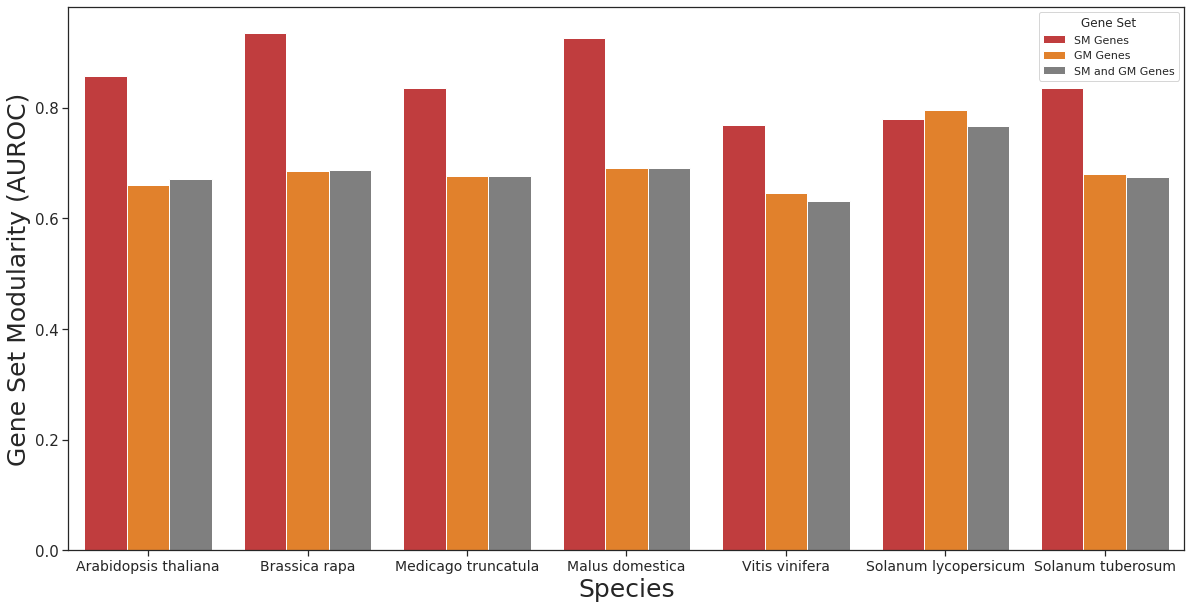

In [49]:
sec_pal = {'SM Genes':'tab:red','GM Genes':'tab:orange','SM and GM Genes':'tab:gray'}
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(ax = ax, y = 'AUC',x = 'Species',hue = 'Gene Set', data = all_egad_results,order = ['Arabidopsis thaliana','Brassica rapa','Medicago truncatula','Malus domestica','Vitis vinifera','Solanum lycopersicum','Solanum tuberosum'], palette= sec_pal )
plt.xlabel("Species", fontsize = 25)
plt.ylabel("Gene Set Modularity (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 15)
#plt.title('Secondary Metabolism Genes form a tighter regulatory module')

In [50]:
#sns.boxplot(y = 'AUC',x = 'Annotation', data = all_egad_results.loc(all_egad_results['Species']=='Arabidopsis thaliana'),order = ['Arabidopsis thaliana','Brassica rapa','Medicago truncatula','Malus domestica','Vitis vinifera','Solanum lycopersicum','Solanum tuberosum'] )


In [51]:
 #all_egad_results.loc[all_egad_results['Species']=='Arabidopsis thaliana']

In [52]:
# all_egad_results = pd.DataFrame(columns = ['AUC','Annotation','Species'])
# current_anno,current_coconet,current_name = egad_annotation_creator(3750)
# current_egad_results = run_egad(go = current_anno, nw = current_coconet, max_count = 2500)
# current_egad_results = current_egad_results.reset_index()
# current_egad_results = current_egad_results.rename(columns = {'index':'Annotation'})

In [53]:

# current_egad_results = current_egad_results.rename(columns = {'index':'Annotation'})
# current_egad_results['Species'] = current_name
# all_egad_results = all_egad_results.append(current_egad_results[['AUC','Annotation','Species']])
# all_egad_results

In [54]:
# species_id = 3880
# current_sm_pd,current_gm_pd,current_name = get_sm_and_gm_pandas(species_id)

# current_sm_pd = pd.DataFrame(current_sm_pd['sp1_gene'])
# currrent_sm_pd =current_sm_pd.drop_duplicates(ignore_index = True)
# current_gm_pd = pd.DataFrame(current_gm_pd['sp1_gene'])
# currrent_gm_pd =current_gm_pd.drop_duplicates(ignore_index = True)
# current_gm_sm_pd = pd.concat([current_sm_pd,current_gm_pd])
# currrent_gm_sm_pd =current_gm_sm_pd.drop_duplicates(ignore_index = True)

# current_gm_pd['GM Genes'] = 1
# current_sm_pd['SM Genes'] = 1
# current_gm_sm_pd['SM and GM Genes'] = 1

# taxa_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Eudiocts_CoCoCoNet_Paths.csv')
# species_path =  taxa_mapper['Path'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
# species_name =  taxa_mapper['Species'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
# species_coconet = read_cococonet(species_path)

# all_genes = pd.DataFrame(data = species_coconet.index, columns = ['sp1_gene'])
# all_genes_annotated = all_genes.merge(current_gm_sm_pd,on = 'sp1_gene',how = 'left')
# all_genes_annotated = all_genes_annotated.fillna(value = 0)

# all_genes_annotated = all_genes_annotated.merge(current_sm_pd,on = 'sp1_gene',how = 'left')
# all_genes_annotated = all_genes_annotated.fillna(value = 0)

# all_genes_annotated = all_genes_annotated.merge(current_gm_pd,on = 'sp1_gene',how = 'left')
# all_genes_annotated = all_genes_annotated.fillna(value = 0)

# all_genes_annotated = all_genes_annotated.set_index(keys = 'sp1_gene')




In [55]:
all_genes_annotated.sum()

NameError: name 'all_genes_annotated' is not defined

In [ ]:
print(sys.path)

['/home/passala/Gene_duplication_project/Code/Whole_genome_comparison_code', '/home/passala/.vscode-server-insiders/extensions/ms-toolsai.jupyter-2021.6.859827477/pythonFiles', '/home/passala/.vscode-server-insiders/extensions/ms-toolsai.jupyter-2021.6.859827477/pythonFiles/lib/python', '/home/passala/miniconda3/envs/py39/lib/python39.zip', '/home/passala/miniconda3/envs/py39/lib/python3.9', '/home/passala/miniconda3/envs/py39/lib/python3.9/lib-dynload', '', '/home/passala/.local/lib/python3.9/site-packages', '/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages', '/data/passala/Python_Utils', '/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg', '/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/UpSetPlot-0.4.1-py3.9.egg', '/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/networkx-2.5.1-py3.9.egg', '/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg', '/home/passala/mini

In [ ]:
import Name_resolver as nr

In [ ]:
test = nr.species_name_resolver(species_1 = 'brome',desired_type = 'scientific')

In [ ]:
test

'Brachypodium distachyon'

In [ ]:
nr.species_name_resolver(spe)

NameError: name 'spe' is not defined